In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import time

In [337]:
user_engage = pd.read_csv('takehome_user_engagement.csv')
user_engage = user_engage.set_index(pd.DatetimeIndex(user_engage['time_stamp']))
user_engage.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [338]:
data_users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1', parse_dates=['last_session_creation_time'])
data_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0


In [339]:
# fill '0' if not invited by anyone
data_users['invited_by_user_id'].fillna(0, inplace=True)


In [340]:
#data_users.dropna(how='any',inplace=True)

In [341]:
data_users.rename(columns = {'object_id':'user_id'},inplace=True)

In [342]:
# check for null values-- looks good
user_engage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 6.3+ MB


In [343]:
# mostly data looks clean except invited_by_user_id which has null values
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
dtypes: float64(1), int64(4), object(5)
memory usage: 937.6+ KB


In [344]:
#groups by user, then date by week, and sums number of visits per week
grouped = user_engage.groupby('user_id').resample('1W').sum()
#removes weeks that were imputed for grouping but are NaN
grouped = grouped[grouped['user_id'].isnull()==False] #.drop('user_id',axis=1)
grouped.head(20)



user_id  visited
user_id time_stamp                  
1       2014-04-27        1        1
2       2013-11-17        2        1
        2013-11-24        0        0
        2013-12-01        2        1
        2013-12-08        0        0
        2013-12-15        2        1
        2013-12-22        0        0
        2013-12-29        2        1
        2014-01-05        2        1
        2014-01-12        2        1
        2014-01-19        0        0
        2014-01-26        0        0
        2014-02-02        0        0
        2014-02-09        6        3
        2014-02-16        4        2
        2014-02-23        0        0
        2014-03-02        0        0
        2014-03-09        2        1
        2014-03-16        2        1
        2014-03-23        0        0

In [345]:
#tags weeks that had less than 3 visits for all users#tags w 
adopted_users = grouped['visited']>=3
#Groups by users and sums up the number of weeks that had 3 or more visits
adopted_users = adopted_users.groupby(level=0).apply(np.sum)
#removes users with no weeks that had 3 or more visits
adopted_users = adopted_users[adopted_users!=0]
adopted_users = pd.DataFrame(adopted_users,index=adopted_users.index)
adopted_users.columns = ['Active Weeks']
adopted_users.head(5)

,Active Weeks
user_id,
2,1
10,52
20,1
33,1
42,68


In [346]:
adopted_user_data = adopted_users.merge(data_users,left_index=True,right_on='user_id',how='inner')

adopted_user_data['adopted']=1
adopted_user_data.head()

,Active Weeks,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0,1
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1401833283,1,1,318,4143.0,1
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1401363998,0,0,58,0.0,1
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1401517749,0,0,401,79.0,1
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1401044707,1,0,235,0.0,1


In [368]:

#Add Active column to origional Data
data_users['adopted']=int(0)
data_users.iloc[list(adopted_user_data.index),10]=1
model_data = data_users.set_index('user_id').sort_index()
index = model_data.last_session_creation_time=='nan'
model_data.loc[index,'last_session_creation_time'] = None



#model_data['last_session_creation_time_clean'] = model_data['last_session_creation_time'].fillna(time.mktime(model_data['creation_time'].timetuple()))
#model_data=model_data.drop(columns='last_session_creation_time')                                                                                

In [372]:
x = model_data.drop(['name', 'email'], axis=1)

# mapping creation source to integers
creation = {'PERSONAL_PROJECTS': 1,
            'GUEST_INVITE': 2,
            'ORG_INVITE': 3,
            'SIGNUP': 4,
            'SIGNUP_GOOGLE_AUTH': 5}
x['creation_source'] = x['creation_source'].map(lambda x: creation[x])

# fill '0' if not invited by anyone
x['invited_by_user_id'].fillna(0, inplace=True)

# drop null rows, just for sanity check
x.dropna( inplace=True)                       
# unix timestamp to datetime string
x['last_session_creation_time'] = x['last_session_creation_time'].map(lambda x: datetime.
                                fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'))
# string to datetime
x['last_session_creation_time'] = pd.to_datetime(x['last_session_creation_time'])
# creation time string to datetime
x['creation_time'] = pd.to_datetime(x['creation_time'])

# create a column usage
x['usage'] = x['last_session_creation_time'] - x['creation_time']
# drop the time columns
x.drop(['creation_time', 'last_session_creation_time'], axis=1, inplace=True)
# if last usage date is less than created date then difference is less than '0'
# So drop 'usage' values less than '0 days'
x = x[x['usage'] >= timedelta(days=0)]

# convert back to unix timestamp, because it is easy to operate on
x['usage'] = x['usage'].map(lambda x: x.total_seconds())

complete = x


In [373]:
y = complete['adopted']
# drop 'usage' feature
x = complete.drop(['adopted'], axis=1)

In [374]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)


In [375]:
logit = LogisticRegression()
logit.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [376]:
pred = logit.predict(X_test)
logit_accuracy = accuracy_score(y_test, pred)
print("Accuracy: %.2f%%" % (logit_accuracy * 100.0))

Accuracy: 72.66%


### Random forest

In [377]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [378]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [ ]:
rf_random.best_params_

In [379]:
best_random_predictions = rf_random.best_estimator_.predict(X_test)
best_random_accuracy = accuracy_score(y_test, best_random_predictions)
print("Accuracy: %.2f%%" % (best_random_accuracy * 100.0))

Accuracy: 94.98%


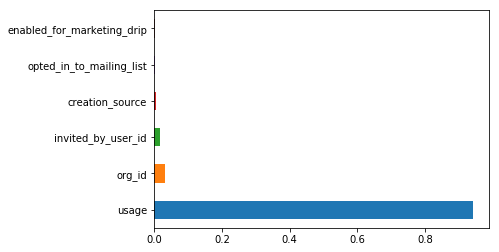

In [382]:
#we can see which are features that influenced the most in prediction 
feat_importances = pd.Series(rf_random.best_estimator_.feature_importances_, index=x.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.show()

The order of Feature importance is

 1. usage
 2. org_id
 3. invited_by_user_id 